In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def fill_missing_with_median(df):
    # 找出缺失值大於0的數值型欄位
    missing_cols = df.columns[df.isnull().sum() > 0]
    
    for col in missing_cols:
        # 檢查是否為數值型欄位，才使用中位數填補
        if df[col].dtype in ['float64', 'int64']:
            median_value = df[col].median()
            df[col] = df[col].fillna(median_value)
        else:
            mode_value = df[col].mode()[0]  # 使用眾數填補
            df[col] = df[col].fillna(mode_value)

def convert_str_columns_to_dummies(df):
    # 找出所有字串型欄位（object 或 category）
    str_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # 使用get_dummies將這些欄位轉換為one-hot encoding
    df_dummies = pd.get_dummies(df, columns=str_cols, drop_first=True, dtype=int)
    return df_dummies

def remove_highly_correlated_features(df, threshold=0.75):
    # 計算相關性矩陣
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    data = pd.DataFrame(df[numeric_cols].values, columns=numeric_cols)
    corr_matrix = data.corr().abs()
    
    # 找出高於閾值的相關性特徵組合
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    
    # 移除高相關性的特徵
    df_reduced = df.drop(columns=to_drop)
    return df_reduced

def plot_heatmap(df):
    # 設置圖形大小
    plt.figure(figsize=(30, 30))
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_data = pd.DataFrame(df[numeric_cols].values, columns=numeric_cols)
    
    # 使用Seaborn繪製熱圖
    sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, square=True) 
    # 顯示圖表
    plt.title('Correlation Heatmap of Features')
    plt.show()

#  讀取資料
> Kaggle Ames Housing Dataset

In [3]:
training_data = pd.read_csv("archive/AmesHousing.csv")
y = training_data['SalePrice']  # 目標變數
training_data

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


# 資料前處理
>* 刪除相關係數過大特徵<br>
>* 刪除缺失值過多特徵<br>
>* 缺失值填補<br>
>* one-hot encoding<br>

In [4]:
#顯示欄位缺失值數量
pd.set_option('display.max_rows', None)
missing = training_data.isnull().sum()
print(missing)

Order                 0
PID                   0
MS SubClass           0
MS Zoning             0
Lot Frontage        490
Lot Area              0
Street                0
Alley              2732
Lot Shape             0
Land Contour          0
Utilities             0
Lot Config            0
Land Slope            0
Neighborhood          0
Condition 1           0
Condition 2           0
Bldg Type             0
House Style           0
Overall Qual          0
Overall Cond          0
Year Built            0
Year Remod/Add        0
Roof Style            0
Roof Matl             0
Exterior 1st          0
Exterior 2nd          0
Mas Vnr Type       1775
Mas Vnr Area         23
Exter Qual            0
Exter Cond            0
Foundation            0
Bsmt Qual            80
Bsmt Cond            80
Bsmt Exposure        83
BsmtFin Type 1       80
BsmtFin SF 1          1
BsmtFin Type 2       81
BsmtFin SF 2          1
Bsmt Unf SF           1
Total Bsmt SF         1
Heating               0
Heating QC      

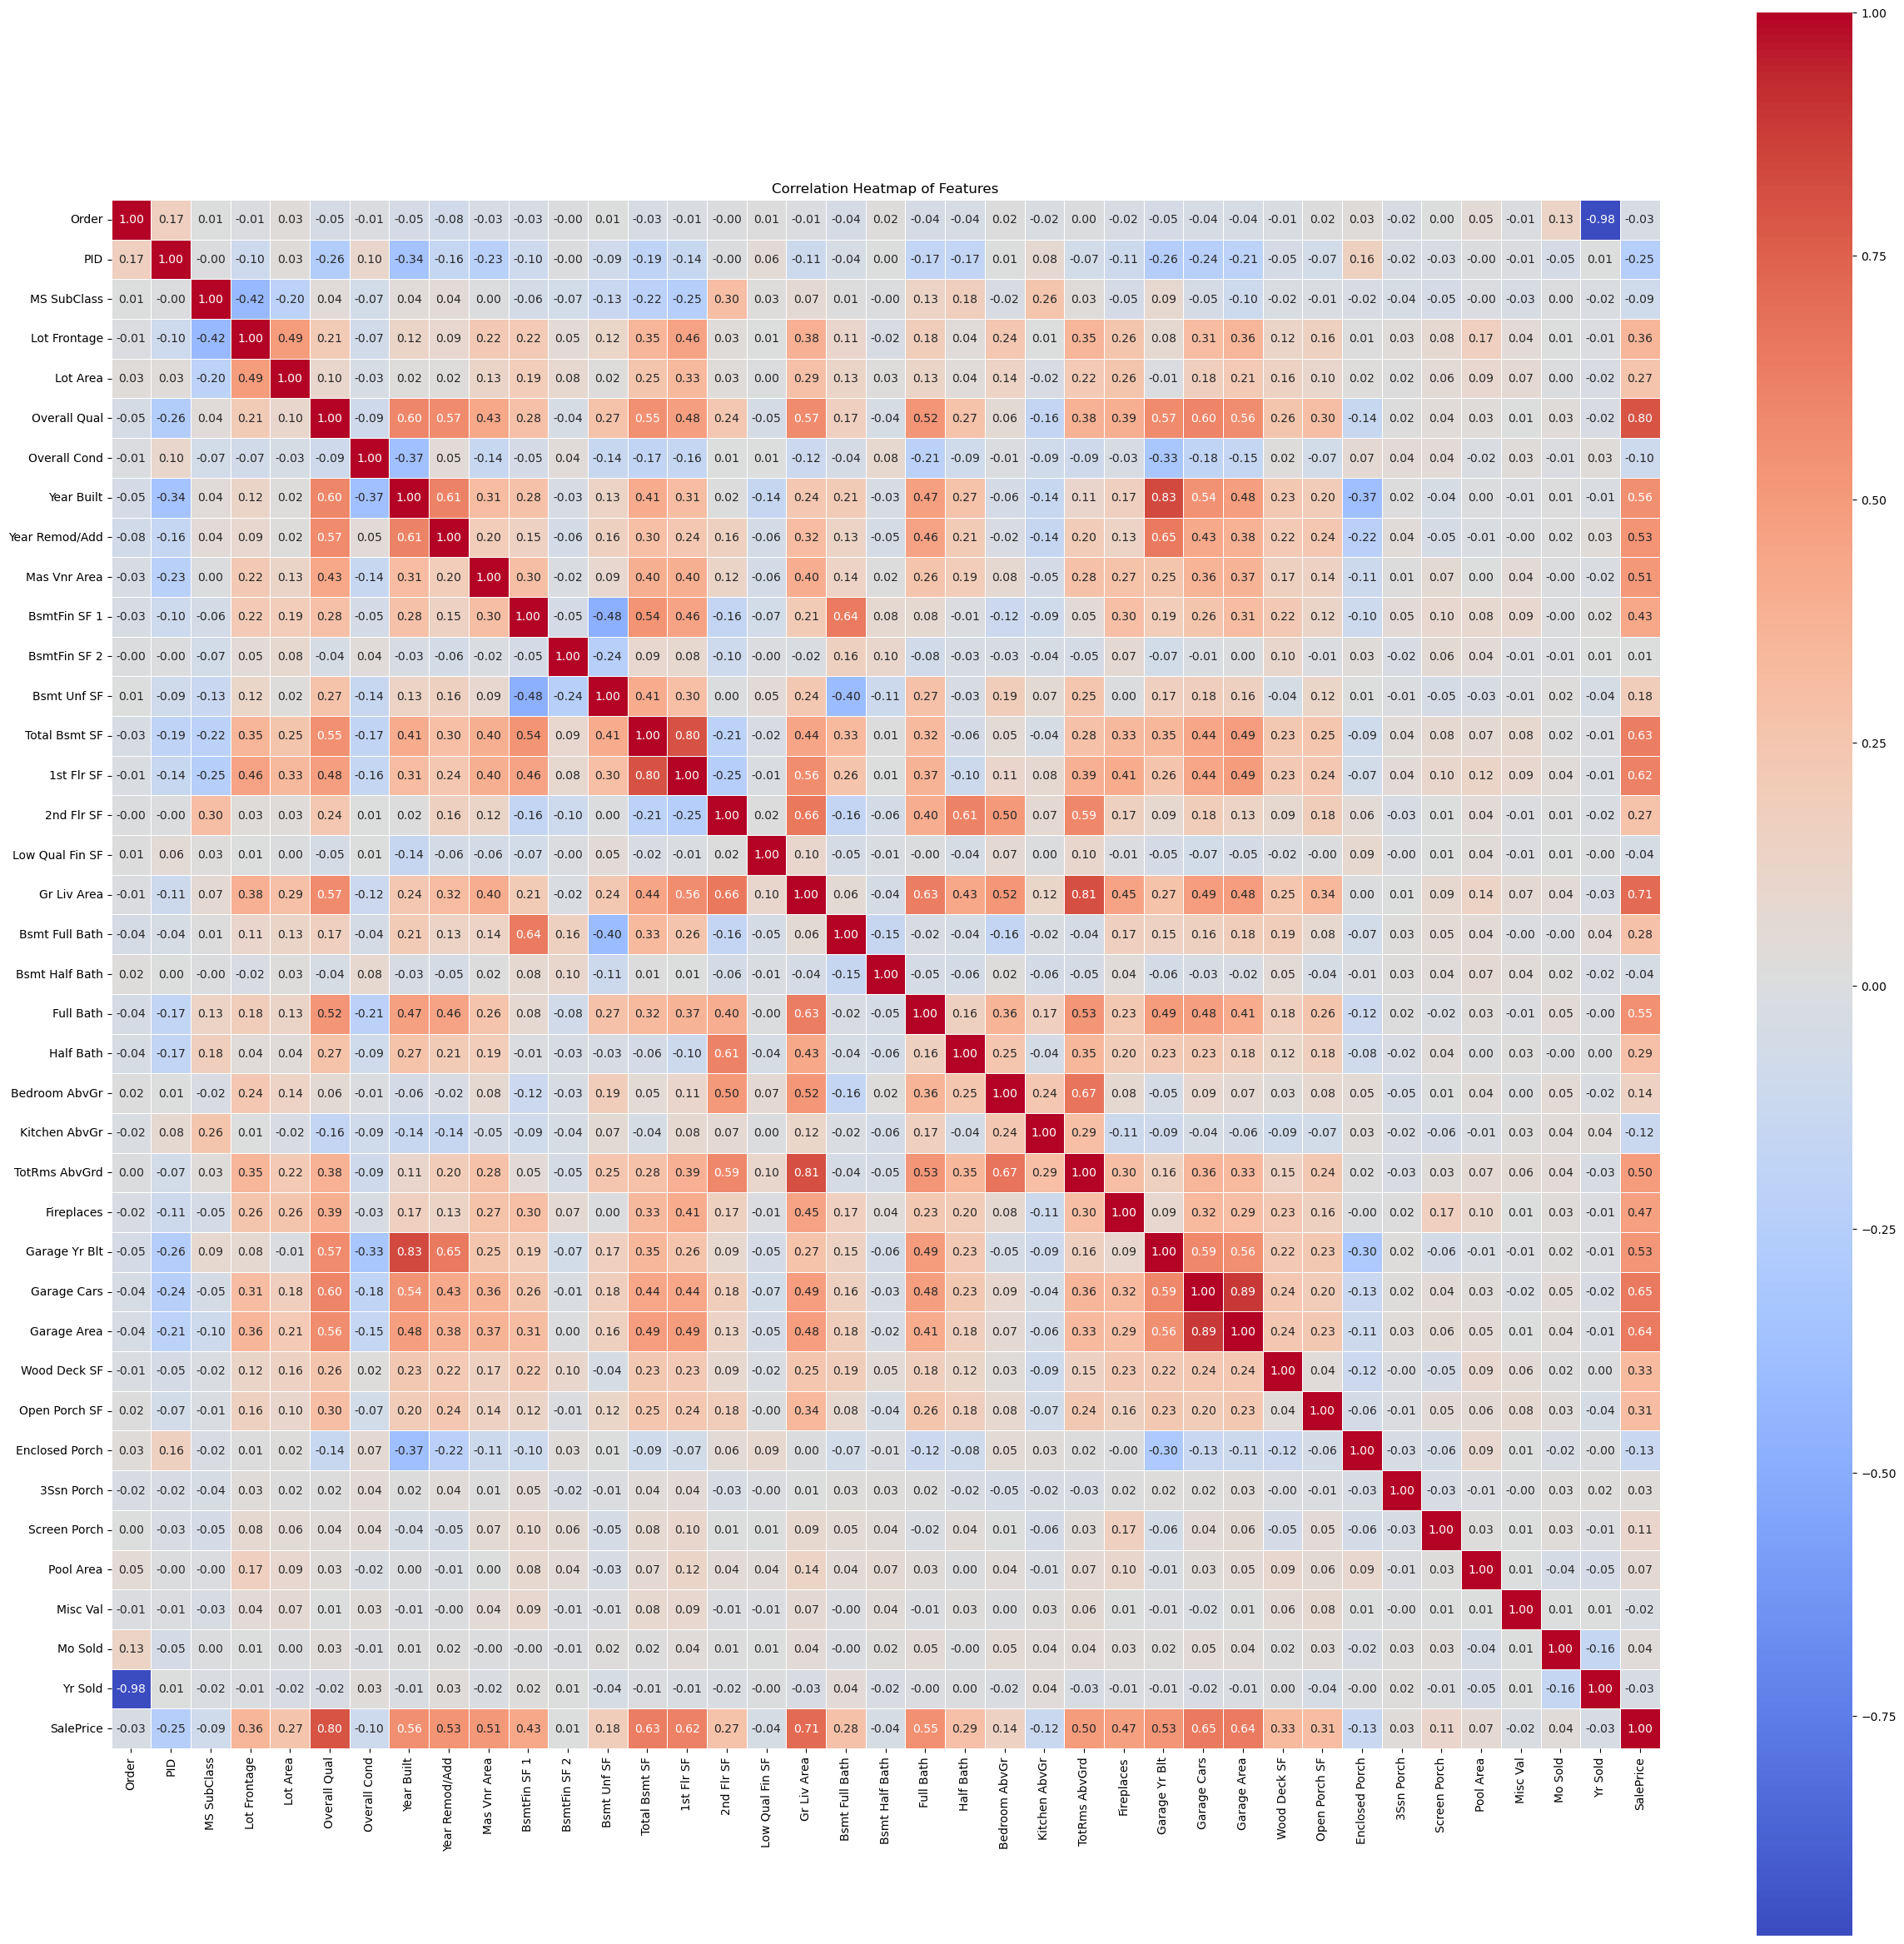

In [5]:
plot_heatmap(training_data)

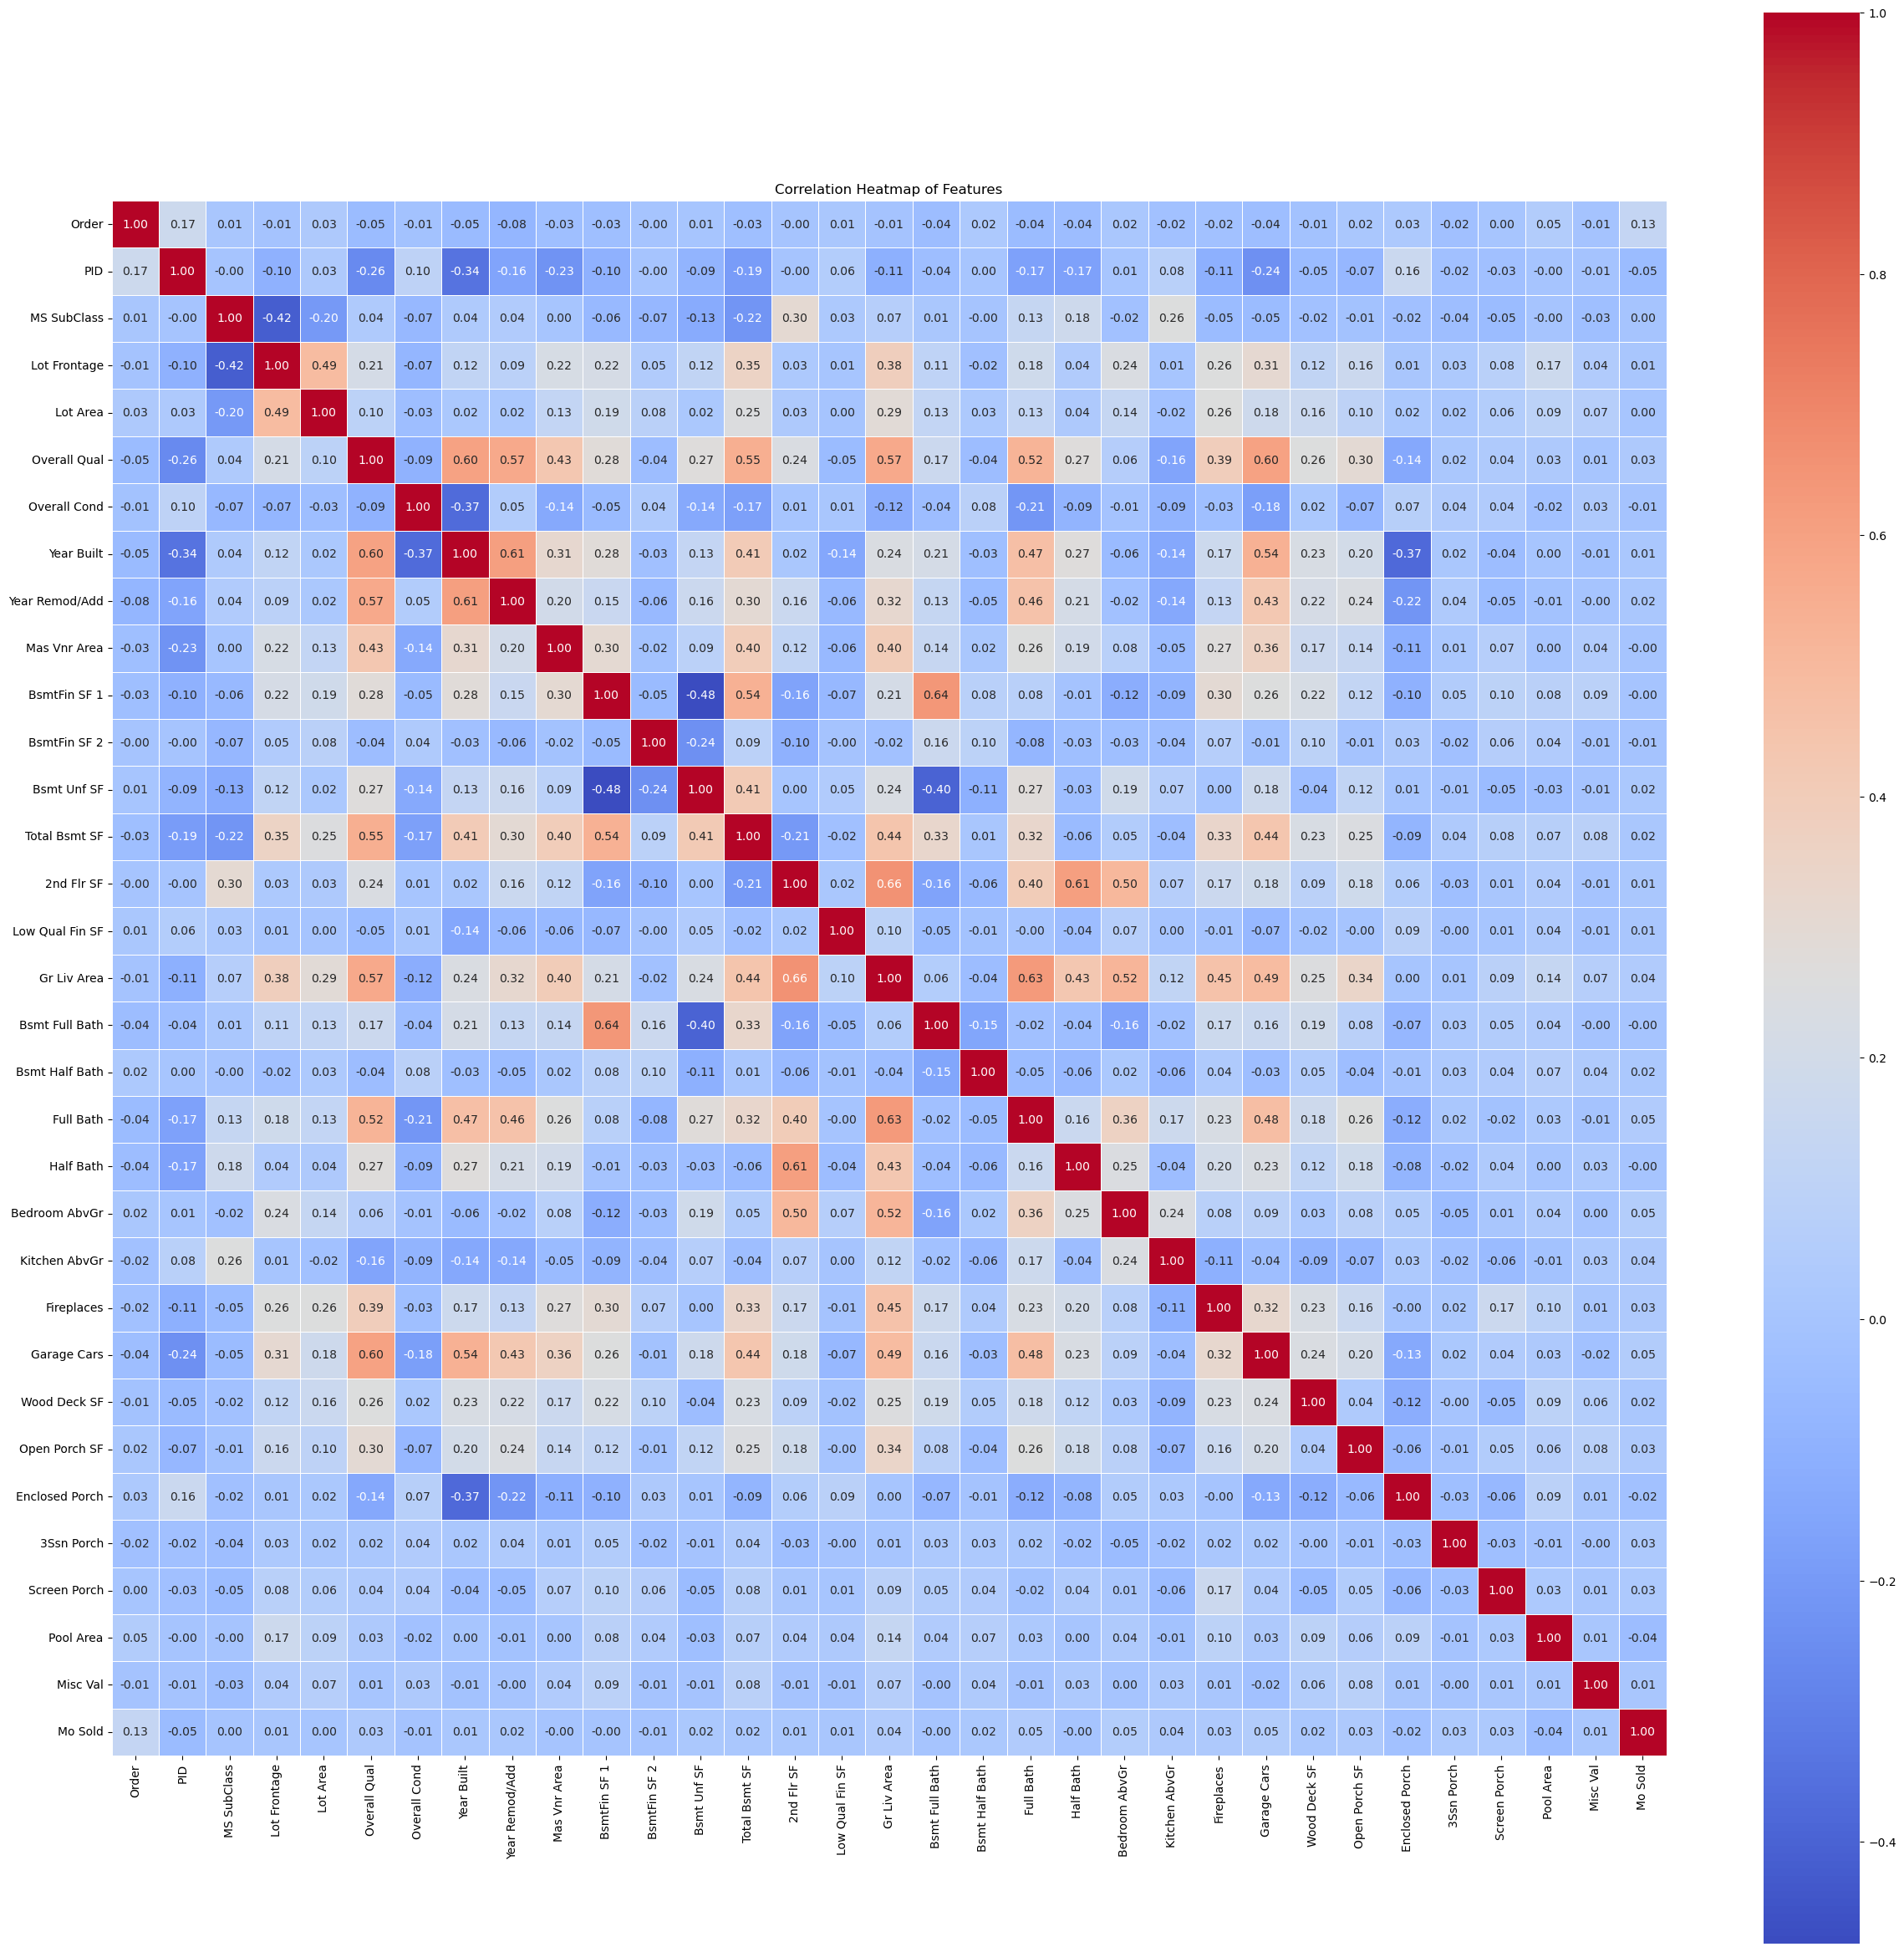

In [6]:
# 對訓練資料移除高相關性的特徵
training_data = remove_highly_correlated_features(training_data)

# 查看結果
plot_heatmap(training_data)

In [7]:
#刪除缺失值過多的特徵
drop_list = ['Order', 'Alley', 'Mas Vnr Type', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']
for dp in drop_list:
    if dp in training_data:
        training_data.drop(dp, axis = 1, inplace = True)

#填補缺失值
fill_missing_with_median(training_data)

#one-hot encoding
training_data = convert_str_columns_to_dummies(training_data)

training_data.head(10)

,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,526301100,20,141.0,31770,6,5,1960,1960,112.0,639.0,...,0,0,0,0,1,0,0,0,1,0
1,526350040,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,0,1,0,0,0,1,0
2,526351010,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,0,1,0,0,0,1,0
3,526353030,20,93.0,11160,7,5,1968,1968,0.0,1065.0,...,0,0,0,0,1,0,0,0,1,0
4,527105010,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,0,1,0,0,0,1,0
5,527105030,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,0,1,0,0,0,1,0
6,527127150,120,41.0,4920,8,5,2001,2001,0.0,616.0,...,0,0,0,0,1,0,0,0,1,0
7,527145080,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,0,1,0,0,0,1,0
8,527146030,120,39.0,5389,8,5,1995,1996,0.0,1180.0,...,0,0,0,0,1,0,0,0,1,0
9,527162130,60,60.0,7500,7,5,1999,1999,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0


# 資料分割
> * 分割資料為訓練資料及測試資料<br>
> * 特徵標準化(Standardization)
> * Lasso 自動選擇重要特徵，降低過擬合的風險

In [8]:
if 'SalePrice' in training_data:
    X = training_data.drop(['SalePrice'], axis = 1) # 特徵
else:
    X = training_data

print("X shape:{}, y shape:{}".format(X.shape, y.shape))

X shape:(2930, 238), y shape:(2930,)


In [9]:
# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 特徵標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lasso = LassoCV()
lasso.fit(X_train_scaled, y_train)

# 篩選重要特徵
importance = np.abs(lasso.coef_)
# 獲取重要特徵的索引
important_features = np.where(importance > np.median(importance))[0]  

# 選取重要特徵
X_train_scaled = X_train_scaled[:, important_features]
X_test_scaled = X_test_scaled[:, important_features]
X_train_scaled

array([[-0.87181667,  0.51464178,  0.03380992, ..., -0.08796935,
        -2.19791851, -0.28579668],
       [ 0.06290638, -0.04704703,  2.30708197, ..., -0.08796935,
        -2.19791851, -0.28579668],
       [ 0.76394867,  0.04656777, -0.03551382, ..., -0.08796935,
         0.45497592, -0.28579668],
       ...,
       [ 0.06290638, -0.23427663, -0.16608596, ..., -0.08796935,
         0.45497592, -0.28579668],
       [-0.17077438,  0.56144919, -0.35032808, ..., -0.08796935,
         0.45497592, -0.28579668],
       [ 0.64710829, -0.42150624, -0.36374558, ..., -0.08796935,
         0.45497592, -0.28579668]])

# 訓練模型
> * 建立 Stacking 模型，使用隨機森林和梯度提升作為基模型，線性回歸作為終極模型<br>
> * 使用 GridSearch 尋找最佳參數

In [12]:
# 訓練隨機森林迴歸模型
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# 訓練梯度提升迴歸模型
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train_scaled, y_train)

# 訓練XGBoost模型
#xgb = XGBRegressor(n_estimators=100, random_state=42)
#xgb.fit(X_train_scaled, y_train)

# 建立 Stacking 模型，使用隨機森林、梯度提升和線性回歸作為基模型，線性回歸作為終極模型
estimators = [
    ('rf',  rf),
    ('gb',  gb)
]

stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_model.fit(X_train_scaled, y_train)

params = {'rf__n_estimators': [10, 50, 100, 200],
          'gb__n_estimators': [700, 800, 900, 1000]
          }

grid_search = GridSearchCV(estimator=stacking_model, param_grid=params,verbose=0, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# 隨機森林預測
y_pred_rf = rf.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("隨機森林模型 RMSE：{}".format(rmse_rf))

# 梯度提升預測
y_pred_gb = gb.predict(X_test_scaled)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print("梯度提升模型 RMSE：{}".format(rmse_gb))

# XGBoost預測
#y_pred_xgb = xgb.predict(X_test_scaled)
#rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
#print("XGBoost模型 RMSE：{}".format(rmse_xgb))

# Stacking 預測
y_pred_stack = stacking_model.predict(X_test_scaled)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
print("Stacking模型 RMSE：{}".format(rmse_stack))

# 顯示最佳參數
print("最佳參數：", grid_search.best_params_)

# 使用最佳模型進行預測
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test_scaled)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
print("GridSearch 優化後的模型 RMSE：{}".format(rmse_optimized))

scores = cross_val_score(best_model, X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
print("score={:.4f}".format(np.sqrt(-scores).mean()))

隨機森林模型 RMSE：27538.561659934156
梯度提升模型 RMSE：27719.419564270836
Stacking模型 RMSE：27806.130388400157
最佳參數： {'gb__n_estimators': 900, 'rf__n_estimators': 10}
GridSearch 優化後的模型 RMSE：28076.82523393286
score=22258.6420


# 模型預測結果視覺化

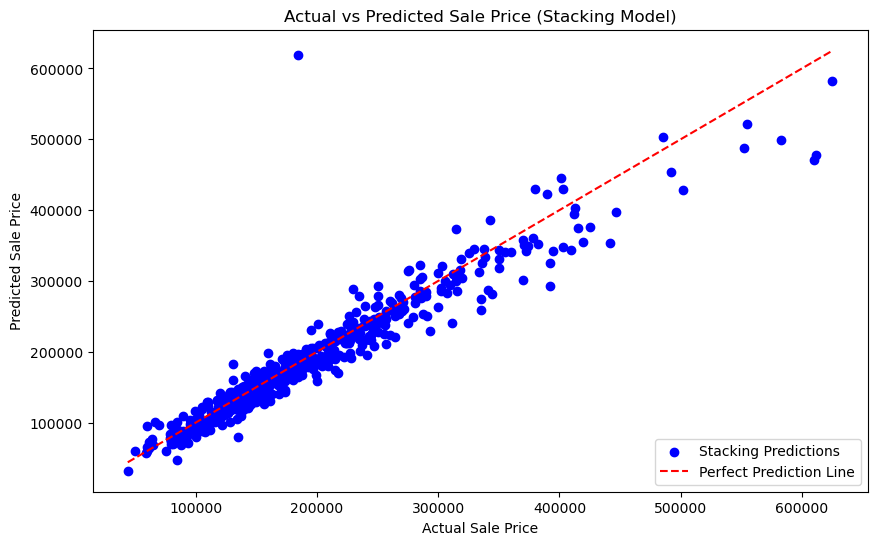

In [13]:
# 設定圖表樣式
plt.figure(figsize=(10, 6))

# 實際 vs 預測結果 (Stacking)
plt.scatter(y_test, y_pred_optimized, color='blue', label='Stacking Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label='Perfect Prediction Line')

# 設定標籤與標題
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price (Stacking Model)')
plt.legend()

# 顯示圖表
plt.show()

# 計算 Accuracy

In [14]:
print("Train Accuracy:{}".format(stacking_model.score(X_train_scaled,y_train)))
print("Test Accuracy:{}".format(stacking_model.score(X_test_scaled, y_test)))

Train Accuracy:0.9576617917796284
Test Accuracy:0.9035639208097419
